In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import branca
import folium
from folium import plugins
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta, time

## Import files

In [2]:
# Full database
df = pd.read_csv('data/complete_dataset.csv', sep=";") 
# Codes of stations associated to their commercial name
stations_codes = pd.read_excel("data/data_stations_codes.xlsx")
# GeoJson files that contains the geometry of the location of station
gdf_points = gpd.read_file("data/data_stations_geometry.geojson")
# Weather file 
df_meteo = pd.read_csv("data/Weather.csv")

/var/folders/qf/zw9hvdy568l59y95w9hy8wvh0000gn/T/ipykernel_14406/3073819265.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/complete_dataset.csv', sep=";")


In [3]:
df["UITVOERTIJD_VERTREK"] = pd.to_timedelta(df["UITVOERTIJD_VERTREK"].astype(str).str.extract(r'(\d{2}:\d{2}:\d{2})')[0], errors='coerce')
df['PLANTIJD_VERTREK'] = pd.to_timedelta(df['PLANTIJD_VERTREK'].str.split('.').str[0], errors='coerce')
df['UITVOERTIJD_AANKOMST'] = pd.to_timedelta(df['UITVOERTIJD_AANKOMST'].str.split('.').str[0], errors='coerce')

This are the infrastructures of our scope. One infrastructure is defined by the succession of the stations if goes throughThese are the infrastructures of our study area. One infrastructure is defined by the succession of the stations if goes through.

In [4]:
# For the high-speed line, it starts between Hoofddorp and Niew-Vennep, 
# so Niew-Venney is included in the infrastructure 

infra = [
    ["Shl", "Hfd", "Rtd"], #High-Speed-line
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gvc"], #Slow line Schiphol-Den Haag Central
    ["Shl", "Hfd", "Nvp", "Ssh", "Ledn", "Dvnk","Vst", "Gvm", "Laa", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"],  #Slow line with no stop at Den Haag Central
    ["Gvc", "Gv", "Gvmw","Rsw", "Dt", "Dtcp","Sdm", "Rtd"], #Slow line Den Haag Central- Rotterdam Central
    ['Rtd', 'Hfd', 'Shl'], #High speed line (reverse)
    ['Gvc', 'Laa', 'Gvm', 'Vst', 'Dvnk', 'Ledn', 'Ssh', 'Nvp', 'Hfd', 'Shl'],  #Slow line Schiphol-Den Haag Central(reverse)
    ['Rtd','Sdm','Dtcp','Dt','Rsw','Gvmw','Gv','Laa','Gvm','Vst','Dvnk','Ledn','Ssh','Nvp','Hfd','Shl'], #Slow line with no stop at Den Haag Central (reverse)
    ['Rtd', 'Sdm', 'Dtcp', 'Dt', 'Rsw', 'Gvmw', 'Gv', 'Gvc'] #Slow line Den Haag Central- Rotterdam Central(reverse)
]

# Names of the infrastructures
labels = [
    "HighSpeed_Shl_Rtd",
    "Slow_Shl_Gvc",
    "Slow_Shl_Rtd",
    "Slow_Gvc_Rtd",
    "HighSpeed_Rtd_Shl",
    "Slow_Gvc_Shl",
    "Slow_Rtd_Shl",
    "Slow_Rtd_Gvc"
]

# Put it into a dictionnayr
infra_dict = dict(zip(labels, infra))

We create the new attribute train_type, which can be TGV, Sprinter, or Intercity

In [6]:
# We assign the TGV based on their trajectory 
df.loc[
    (df["TRAJECT"].isin(["Shl_Rtd", "Rtd_Shl"])),
    "train_type"
] = "TGV"

# We also assign the IC based on their trajectory (it doesn't cover exceptions ->>> data cleaning)
mask = (df["TRAJECT"].isin(["Dt_Gv", "Gv_Dt", "Ledn_Shl", "Shl_Ledn", 
                                             "Ledn_Gvc", "Gvc_Ledn","Rtd_Gv", "Gv_Rtd","Dt_Rtd", "Rtd_Dt",
                                             "Dt_Sdm", "Sdm_Dt", "Ledn_Gv", "Gv_Ledn",
                                              "Ledn_Laa", "Laa_Ledn"])    
        & df["train_type"].isna()
)
bewegings_to_update = df.loc[mask, "BEWEGINGNUMMER"].unique()
df.loc[
    df["BEWEGINGNUMMER"].isin(bewegings_to_update),
    "train_type"
] = "IC"

# We assume the rest of them are sprinters
df.loc[
    pd.isna(df["train_type"]) ,
    "train_type"
] = "Sprinter"



# Map visualisations

First, we need to associate each station to it's geometry. 

The geometries of the stations were found on Internet and downloaded through "gdf_points". To made the link with this table, we also had to download a database giving the correspondencies between stations' codes and stations' commercial names.

In [7]:
# The list of the stations we use is the list of the uniques elements of column "station1".
stations = df["station1"].unique().tolist()

# Associate the stations of the list with their full commercial name
stations_geometries = stations_codes.loc[stations_codes["Code"].isin(stations)]

# Merge the list of stations with their geometry stocked in gdf_points 
stations_geometries = gpd.GeoDataFrame(stations_geometries.merge(
    gdf_points[["name","geometry"]], 
    left_on="Commercial Name", 
    right_on="name"), geometry='geometry')


The table intermediate_sections will give the same trips as the original dataframe, but splitted into sections that correspond to the infrastructure, in order to get the occupation of tracks

In [8]:
intermediate_sections = df.copy() 

# Create a list that will store all the rows corresponding to some infrastructure sub-sections of 
# the already existing TRAJECTS
new_rows_all = [] 

# This list will store all the rows that were divied into subsections. Some of them already fit the 
# infrastructure (ex : traject between Dt and Dtcp), so it won't be split.
rows_to_delete = []

for i, row in intermediate_sections.iterrows():
    found = False
    for infrastructure in infra: # Find the infrastructure that contains this traject
        if found == False and row["station1"] in infrastructure and row["station2"] in infrastructure[infrastructure.index(row["station1"])+2:]:
            intermediate_stops = infrastructure[infrastructure.index(row["station1"]): infrastructure.index(row["station2"])+1]
            for j in range(1, len(intermediate_stops)):
                section = f"{intermediate_stops[j-1]}_{intermediate_stops[j]}"
                #Each inserted row corresponds to a infrastructure section crossed by the train
                inserted_row = row.copy()
                inserted_row["TRAJECT_infra"] = section
                inserted_row["station1"] = intermediate_stops[j-1]
                inserted_row["station2"] = intermediate_stops[j]
                new_rows_all.append(inserted_row)
                df.loc[i, "global_infra_name"] = [k for k, v in infra_dict.items() 
                                             if v == infrastructure][0] # Name of the infra 
            rows_to_delete.append(i)
            found = True
        if found==False and row["station1"] in infrastructure :  
            if row["station2"] in infrastructure[infrastructure.index(row["station1"])+1:]:
                df.loc[i, "global_infra_name"] = [k for k, v in infra_dict.items() if v == infrastructure][0]
                found = True 

intermediate_sections=intermediate_sections.drop(rows_to_delete)
intermediate_sections = pd.concat([intermediate_sections, pd.DataFrame(new_rows_all)], ignore_index=True)
intermediate_sections.loc[pd.isna(intermediate_sections["TRAJECT_infra"]), "TRAJECT_infra"] = intermediate_sections["TRAJECT"]



New attribute for intermediate_sections : the number of tracks per section (and per direction)

In [9]:
number_of_tracks = pd.DataFrame(intermediate_sections["TRAJECT_infra"].unique(),columns=["TRAJECT_infra"])

# Based on observations on openrailwaymap.org, all the sections have 2 tracks, 
# except a few of them listed below
number_of_tracks["n_of_tracks"] = 2
one_track_sections = ["Dtcp_Sdm", "Sdm_Dtcp","Ledn_Ssh", "Ssh_Ledn", "Ssh_Nvp", "Nvp_Ssh","Hfd_Rtd","Hfd_Rtd"]
number_of_tracks.loc[number_of_tracks["TRAJECT_infra"].isin(one_track_sections), "n_of_tracks"] = 1

# Merge with intermediate_sections to create the attribute
intermediate_sections= pd.merge(
    number_of_tracks, intermediate_sections, 
    on="TRAJECT_infra"
)
small_delays = intermediate_sections.copy()


In [62]:
# Merge with the geometries of the origin and arrival stations
intermediate_sections = intermediate_sections.merge(
        stations_geometries, 
        left_on="station1",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Origin_com_name", 
            "Code" : "Origin_code",
            "geometry" : "geometry_origin"
            })
    
intermediate_sections = intermediate_sections.merge(
        stations_geometries, 
        left_on="station2",
        right_on = "Code",
        ).rename(columns = {
            "Commercial Name" : "Destin_com_name", 
            "Code" : "Destin_code",
            "geometry" : "geometry_destination"
            })


To display the maps, we use the geodataframe gdf_segments that contains the geometry of the sections and it's informations.

In [63]:
gdf_segments = intermediate_sections[["TRAJECT_infra","geometry_origin", 
                                      "geometry_destination","station1","station2"]].drop_duplicates()

# Based on the geometries of arrival and departure stations, we create a line geometry
gdf_segments['geometry'] = gdf_segments.apply(
    lambda row: LineString([row['geometry_origin'], row['geometry_destination']]), 
    axis=1
)
gdf_segments = gpd.GeoDataFrame(gdf_segments, geometry='geometry')

### Some useful functions to dispay the maps

In [64]:
def merge_with_geometries(tab) : 
    """
    It merges a table tab, containing information about sections, with the table containing 
    the geometries. 
    Args : 
        tab (DataFrame) : Dataframe with informations about the intermediate sections
    Returns : 
        new_gdf (GeoDataFrame) : Same dataframe but with each section associated to it's geometry
    """
    new_gdf = gdf_segments.merge(
    tab,
    left_on="TRAJECT_infra",
    right_on="TRAJECT_infra",
    how="left"
    )
    new_gdf = new_gdf.set_crs("EPSG:4326", allow_override=True)
    return new_gdf


In [65]:
def display_map(gdf_segments, attribute,alias, valuemin, valuemax) : 
    """
    It displays the map using folium
    Code from the 1st workshop on September 9 
    Args : 
        gdf_segments (GeoDataFrame) : Dataframe with informations and geometries of the intermediate sections 
        attribute (str) : the name of the attribute (as it appears in the dataframe) that will be displayed
        alias (str) : How the attribute should be display in the legend of the ToolTip
        valuemin (int) : Minimum value of the attribute (for the colormap)
        valuemax (int) : Maximum value of the attribute (for the colormap)
    Returns : 
        poly_map (folium.Map) 
    """
    # create learn colormap interpolating 3 colors
    colors = branca.colormap.LinearColormap(
        ['green', 'yellow', 'red'], vmin=valuemin, vmax=valuemax)
        
    # define style function
    def raster_choropleth(row):
        return {
            "color": colors(row['properties'][attribute]),
            "weight" : 5,
            "fillOpacity": 0.75,
        }
    
    # create base map    
    poly_map = folium.Map(
            location=[52.10, 4.30], # The map is centered on Leiden 
            zoom_start=10
        )
    
    # overlay choropleth
    gjson = folium.features.GeoJson(
        gdf_segments[['TRAJECT_infra', attribute, 'geometry']],
        style_function=raster_choropleth,
        ).add_to(poly_map)

    # Draw the triangle arrow
    for idx, row in gdf_segments.iterrows():
        dest_point = row["geometry"].coords[-1]
        origin_point= row["geometry"].coords[0]    
        line_coords = list(row['geometry'].coords)
        if len(line_coords) >= 2:
            p1, p2 = line_coords[-2], line_coords[-1]
            import math
            angle = math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))             
            folium.RegularPolygonMarker(
                location=[dest_point[1], dest_point[0]],
                color=colors(row[attribute]),
                fill_opacity=1,
                fill_color = colors(row[attribute]),
                number_of_sides=3,  
                radius=5,
                rotation=-angle,
                weight = 1,
                popup=row['TRAJECT_infra']
            ).add_to(poly_map)
    
    # add Tooltip
    folium.features.GeoJsonTooltip(
        fields=['TRAJECT_infra',attribute],
        aliases=['Segment', alias]
    ).add_to(gjson)
    
    poly_map.add_child(colors)      
    return poly_map

In [66]:
def simple_offset_perpendicular(point, offset, direction_vector):
    """ 
    It adds an offset to a linestring. This function is used in the function apply_offset_perpendicular
    Args : 
        point (shapely.geometry.point.Point) : geometry of the station 
        offset (float) : offset applied in meters
        direction_vector (tupe) : directional vectore of the line (dx, dy)
    Returns : 
        point (shapely.geometry.point.Point) : geometry of the station with the offset 
    """
    dx, dy = direction_vector
    length = np.sqrt(dx**2 + dy**2)
    if length == 0:
        return point
    # normalized perpendicular vector
    px = -dy / length
    py = dx / length

    # approximative conversion from meters to degrees
    dlat = py * offset / 111000
    dlon = px * offset / (111000 * np.cos(np.radians(point.y)))
    
    return Point(point.x + dlon, point.y + dlat)

def apply_offset_perpendicular(gdf_segments, offset=200):
    """ 
    It adds an offset to parrallel line (so that they are not displayed with an overlap on the map). 
    Args : 
        gdf_segments (GeoDataFrame) : Dataframe with the geometries of the sections 
        offset (float) : offset that will be applied 
    Returns : 
        gdf_segments (GeoDataFrame) : Dataframe with the geometries of the sections, some 
        of them with an offset 
    """
    new_geometries = []
    
    for i, row in gdf_segments.iterrows():
        line = row['geometry']
        coords = list(line.coords)
        
        # direction of the line for the first to the end point
        dx = coords[-1][0] - coords[0][0]
        dy = coords[-1][1] - coords[0][1]

        # for the lines in the opposite directions, we take the reverse value
        applied_offset = offset if row.get("direction", "Forward") == "Forward" else -offset

        # create the new stations with an offset
        new_coords = [simple_offset_perpendicular(Point(x, y), applied_offset, (dx, dy)) for x, y in coords]
        new_geometries.append(LineString([(p.x, p.y) for p in new_coords]))
    
    gdf_segments['geometry'] = new_geometries
    return gdf_segments

# Map of crowding


In [67]:
crowding_by_traject = intermediate_sections.groupby(["TRAJECT_infra"] )[["REALISATIE","PROGNOSE_REIZEN","AFWIJKING"]].sum().reset_index()
gdf_segments_crowding = merge_with_geometries(crowding_by_traject)
gdf_segments_crowding = apply_offset_perpendicular(gdf_segments_crowding, 220)
poly_map = display_map(gdf_segments_crowding, "REALISATIE", "Crowding", gdf_segments_crowding["REALISATIE"].min(), gdf_segments_crowding["REALISATIE"].max())
poly_map

There is still this problem of untrusted notebook on Github but here is what the output looks like for the moment (basic screenshot) : 


<img src="images/crowding2.png" alt="Screenshot" width="50%">

# Map of delay per period

In [15]:
intermediate_sections["delay"] = pd.to_datetime(intermediate_sections["delay"])
intermediate_sections["delay_seconds"] = (
    intermediate_sections["delay"].dt.hour * 3600
    + intermediate_sections["delay"].dt.minute * 60
    + intermediate_sections["delay"].dt.second
)


/var/folders/qf/zw9hvdy568l59y95w9hy8wvh0000gn/T/ipykernel_78674/977051802.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  intermediate_sections["delay"] = pd.to_datetime(intermediate_sections["delay"])


In [16]:
def delay_per_section(period) : 
    """ 
    It aggregates the data about delays on the sections
    Args : 
        period (string) : Name of the period of the day. It can be : Ochtendspits, Avondspits, 
        Weekend, Daluren 
    Returns : 
        gdf_segments_delay (GeoDataFrame) : Aggregated data about the delays on the sections
    """
    delay_per_period = (
        intermediate_sections.loc[intermediate_sections["DAGDEELTREIN"]==period]
        .groupby("TRAJECT_infra")
        .agg(
            mean_delay=("delay_seconds", "mean"),
        )
        .reset_index()
    )

    gdf_segments_delay = merge_with_geometries(delay_per_period)
    return gdf_segments_delay


## Delay in the morning

In [17]:
gdf_segments_delay = delay_per_section("Ochtendspits")

poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

## Delay in the afternoon

In [18]:
gdf_segments_delay = delay_per_section("Avondspits")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

## Delay on off-peak hours

In [19]:
gdf_segments_delay = delay_per_section("Daluren")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

## Delay on the week-end

In [20]:
gdf_segments_delay = delay_per_section("Weekend")
poly_map = display_map(apply_offset_perpendicular(gdf_segments_delay, 220), 
                       "mean_delay", 
                       "Average delay (seconds)", 
                       0, 
                       200)
poly_map

# Map of frequency Tuesday Morning

In [21]:
frequency_tuesday_morning = (
    intermediate_sections.loc[
        (intermediate_sections["DAGDEELTREIN"]=="Ochtendspits") & 
        (intermediate_sections['WEEK_DAG_NR']==2)
    ]
    .groupby("TRAJECT_infra")
    .size()  
    .reset_index(name="count") 
)
gdf_segments_tuesday = merge_with_geometries(frequency_tuesday_morning)
gdf_segments_tuesday["frequency"] = gdf_segments_tuesday["count"]/2.5/4

gdf_segments_tuesday = apply_offset_perpendicular(gdf_segments_tuesday, 220)
poly_map = display_map(gdf_segments_tuesday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map

# Map of frequency Saturday evening

In [22]:
frequency_saturday = (
    intermediate_sections.loc[
        (intermediate_sections['PLANTIJD_VERTREK']<pd.to_timedelta("16:00:00")) & 
        (intermediate_sections['PLANTIJD_VERTREK']>pd.to_timedelta("15:00:00")) & 
        (intermediate_sections['WEEK_DAG_NR']==6)
    ]
    .groupby("TRAJECT_infra")
    .size()  
    .reset_index(name="count")
)
gdf_segments_saturday = merge_with_geometries(frequency_saturday)
gdf_segments_saturday["frequency"] = gdf_segments_saturday["count"]/4

gdf_segments_saturday = apply_offset_perpendicular(gdf_segments_saturday, 220)
poly_map = display_map(gdf_segments_saturday, "frequency", "Frequency (trains per hour)", 2, 20)
poly_map

# Average deviation per route (map)

In [23]:
average_deviations = intermediate_sections.groupby("TRAJECT_infra").agg({
                        "REALISATIE": "mean",
                        "PROGNOSE_REIZEN": "mean",
                        "AFWIJKING": "mean"
}).reset_index()
                        
gdf_average_deviations = merge_with_geometries(average_deviations)
gdf_average_deviations = apply_offset_perpendicular(gdf_average_deviations, 220)

In [24]:
poly_map = display_map(
    gdf_average_deviations, 
    "AFWIJKING", 
    'Average deviation per section', 
    gdf_average_deviations["AFWIJKING"].min(), 
    gdf_average_deviations["AFWIJKING"].max())

poly_map

# Average deviation per route (bar chart)

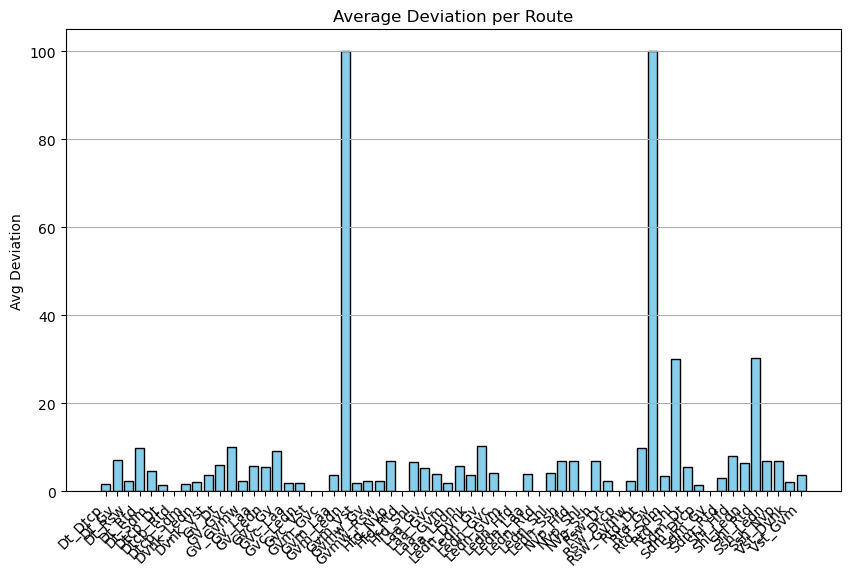

In [25]:
# Group by route
route_stats = df.groupby("TRAJECT").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean",
    "AFWIJKING": "mean"
}).reset_index()

plt.figure(figsize=(10,6))
plt.bar(route_stats["TRAJECT"], route_stats["AFWIJKING"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg Deviation")
plt.title("Average Deviation per Route")
plt.grid(axis="y")
plt.show()

# Quality of previsions through the day

We group the realised departures times in 10-minutes intervals

In [26]:
# Creation of multiple time intervals to group the trips

quality_of_previsions = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

# convert to datetime
quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["UITVOERTIJD_AANKOMST"].apply(
    lambda td: (datetime.min + td).time() 
)

# We create a new feature to group the real departure times by 10-minutes intervals 

def make_intervals(t,interval=10, mode="minute"):
    """
    It rounds a time of date format 
    Args : 
        t : time in datetime format
        interval (int) : interval for the rounding (exemple : 10-minutes intervals)
        mode (string) : it gives the unit of the interval. Either "minute" or "second"
    Retunrs : 
        rounded time in date format
    """
    if t is pd.NaT or t is None:
        return None
    dt = datetime.combine(datetime.today(), t)
    if mode == "minute" : 
        total = dt.hour * 60 + dt.minute
    elif mode == "second" : 
        total = dt.hour * 3600 + dt.minute * 60 + dt.second
    rounded = round(total / interval) * interval
    if mode == "minute" : 
        dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(minutes=rounded)
    elif mode == "second" : 
        dt_rounded = dt.replace(hour=0, minute=0, second=0, microsecond=0) + timedelta(seconds=rounded)
    return dt_rounded.time()

quality_of_previsions["round_UITVOERTIJD_AANKOMST"] = quality_of_previsions["round_UITVOERTIJD_AANKOMST"].apply(lambda t : make_intervals(t,10,"minute"))

mean_deviation = quality_of_previsions.groupby('round_UITVOERTIJD_AANKOMST').agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
}).reset_index()



And plot the diagram

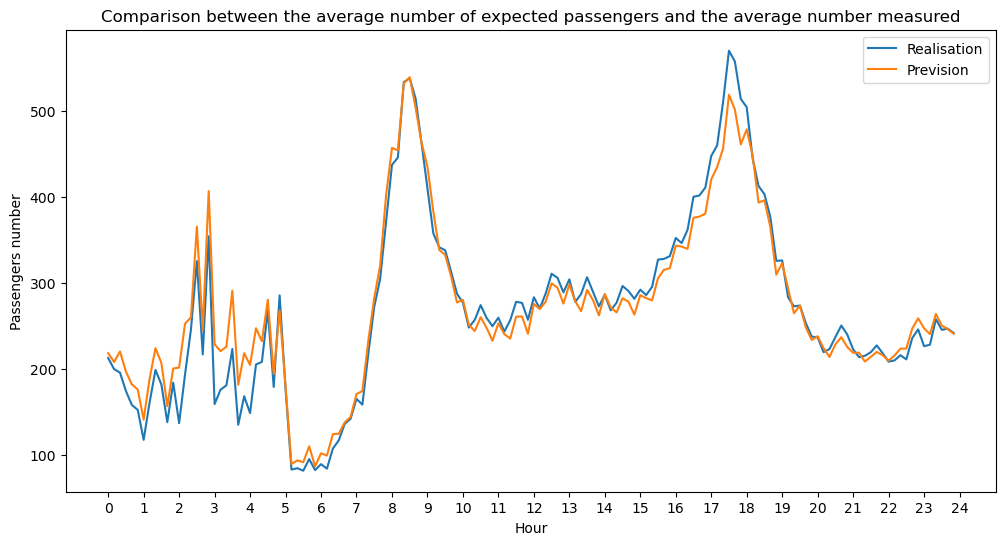

In [27]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)
mean_deviation['minutes'] = mean_deviation['round_UITVOERTIJD_AANKOMST'].apply(
    lambda t: t.hour * 60 + t.minute
)

# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_deviation['minutes'], mean_deviation['REALISATIE'], label='Realisation')
plt.plot(mean_deviation['minutes'], mean_deviation['PROGNOSE_REIZEN'], label='Prevision')

plt.xticks(range(0, 24*60+1, 60), [f"{h}" for h in range(25)])  # ticks every hours
plt.xlabel("Hour")
plt.ylabel("Passengers number")
plt.title("Comparison between the average number of expected passengers and the average number measured")
plt.legend()
plt.show()

# Prevision error compared to the delay of the train at departure time

In [28]:
# We group the delays to intervals of 30 secondes for a nice plot

error_compared_to_delay = df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()
error_compared_to_delay["delay"] =pd.to_datetime(error_compared_to_delay["delay"], format="%H:%M:%S").dt.time
error_compared_to_delay["delay_round"] = error_compared_to_delay["delay"].apply(lambda t : make_intervals(t,30, "second"))


In [29]:
# We group the values for each delay interval

mean_delay = error_compared_to_delay.groupby("delay_round").agg({
    "REALISATIE": "mean",
    "PROGNOSE_REIZEN": "mean", 
    'AFWIJKING' : "mean",
}).reset_index()

mean_delay=mean_delay.loc[mean_delay["delay_round"] < time(hour=2)]


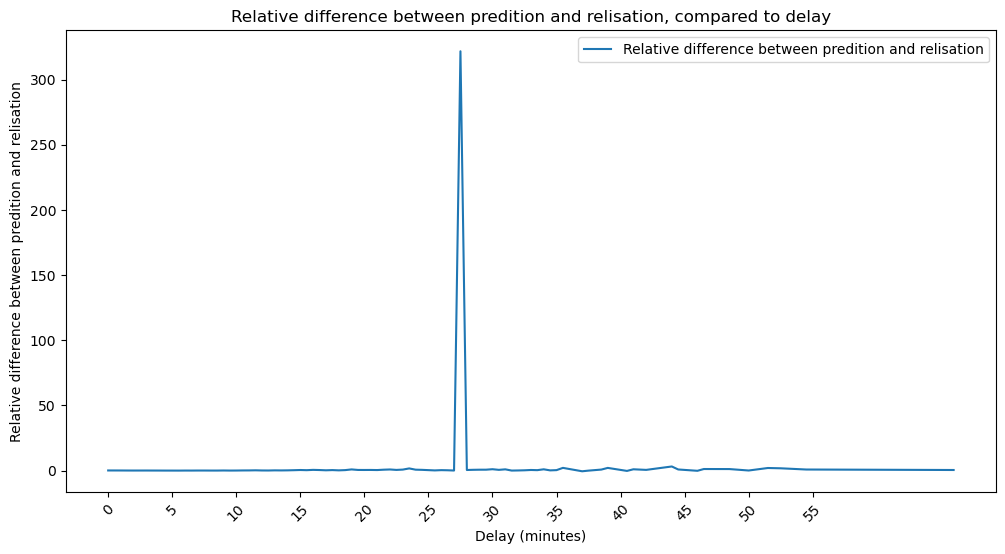

In [30]:
# This column will serve only for the plot (matplotlib cannot put date format on an x-axis)
mean_delay['seconds'] = mean_delay["delay_round"].apply(
    lambda t: t.hour * 3600 + t.minute*60 + t.second)

# Plot the diagram
plt.figure(figsize=(12, 6))
plt.plot(mean_delay['seconds'], mean_delay['AFWIJKING'], label='Relative difference between predition and relisation')

ticks = range(0, 3600, 300)  # tous les 5 minutes (300 secondes)
labels = [f"{m}" for m in range(0, 60, 5)]
plt.xticks(ticks, labels, rotation=45)
plt.xlabel("Delay (minutes)")
plt.ylabel('Relative difference between predition and relisation')
plt.title('Relative difference between predition and relisation, compared to delay')
plt.legend()
plt.show()

#the pic is due to an aberration at 27:30 delay. Data should be cleaned  

# Average delay on all of the network 

First, we have to group the line of the dataframes to only get 1 delay per train. 
But for this purpose, two approaches can be used. Lets take the example of a train running from Shl to Gvc. Let's say that this train has a 11min38 delay from Shl to Hfd, 11min43 delay from Hfd to Ledn, and a 11min35 delay from Ledn to Gvc (it catches up a little on the last section). 
- First approach : we take the maximum delay encountered by the train. For this example, it should be 11min43
- Second approach : we take te final delay of the train at it's final station. For this example, it should be 11min35.

I think that the second approach is the most relevant one, but the two of them are written below, and one just need to comment/uncomment the two lines.

In [31]:
df_delay_per_train= df.loc[(df["Cancelled"]==False) & (df["ExtraTrain"]== False)].copy()

df_delay_per_train["delay"] =pd.to_datetime(df_delay_per_train["delay"], format="%H:%M:%S").dt.time
df_delay_per_train["delay_seconds"] = df_delay_per_train["delay"].apply(lambda t: t.hour*3600 + t.minute*60 + t.second)

#FIRST APPROACH : 
#idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"])["delay_seconds"].idxmax()

#SECOND APPROACH : 
idx = df_delay_per_train.groupby(["DAGNR", "BEWEGINGNUMMER"]).tail(1).index


df_delay_per_train = df_delay_per_train.loc[idx].reset_index(drop=True)

def mean_delays(period, df) : 
    df_selection = df.loc[df["DAGDEELTREIN"]==period]
    mean = df_selection["delay_seconds"].mean()
    return (datetime.min + timedelta(seconds=mean)).time()

morning = mean_delays("Ochtendspits", df_delay_per_train)
evening = mean_delays("Avondspits", df_delay_per_train)
offpeak = mean_delays("Daluren", df_delay_per_train)
weekend = mean_delays("Weekend", df_delay_per_train)

print(
    f"Mean delay in the morning peak: {morning.hour} hour(s) {morning.minute} minute(s) {morning.second} second(s) \n"
    f"Mean delay in the evening peak: {evening.hour} hour(s) {evening.minute} minute(s) {evening.second} second(s) \n"
    f"Mean delay in the off peak: {offpeak.hour} hour(s) {offpeak.minute} minute(s) {offpeak.second} second(s)\n"
    f"Mean delay in the week-end: {weekend.hour} hour(s) {weekend.minute} minute(s) {weekend.second} second(s)"
)

Mean delay in the morning peak: 0 hour(s) 1 minute(s) 4 second(s) 
Mean delay in the evening peak: 0 hour(s) 1 minute(s) 38 second(s) 
Mean delay in the off peak: 0 hour(s) 1 minute(s) 18 second(s)
Mean delay in the week-end: 0 hour(s) 1 minute(s) 8 second(s)


# Influence of small delays


## Propagation of delays

We want to know, if a train is delayed, what is the influence of the trains after occupying the same infrastructure. For this purpose, we define a new attribute "order infrastructure" on intermediate sections.

In [10]:
small_delays['UITVOERTIJD_VERTREK_dt'] = small_delays['UITVOERTIJD_VERTREK']

# To make accurate calculations, we decide that a day starts at 5 a.m., so we need to "change the day
# number" of train running from 0 a.m. to 5 a.m. 
small_delays.loc[small_delays['UITVOERTIJD_VERTREK_dt'] < pd.Timedelta(hours=5), 'UITVOERTIJD_VERTREK_dt'] -= pd.Timedelta(days=1)

small_delays["delay"] = pd.to_datetime(small_delays["delay"], format="%H:%M:%S").dt.time
small_delays['delay_seconds'] = (small_delays['delay'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second))

# We sort the lines with the same order as they occupy the infrastructures
small_delays['ORDER_ON_INFRA'] = (
    small_delays
    .sort_values(by=['DAGNR', 'station1', 'station2', 'UITVOERTIJD_VERTREK_dt'])
    .groupby(['DAGNR', 'station1', 'station2'])
    .cumcount() + 1     
)

small_delays = small_delays.sort_values(
    by=['DAGNR', 'station1', 'station2', 'ORDER_ON_INFRA']
).reset_index()

First example : 

In [33]:
def select_following_trains(i, number=20) : 
    """
    It selects the trains 20 next trains that run on the same infrastructure after train of index i
    Args : 
        i (int) : index of the train we want to consider
        number (float) : number of trains after train i we want to show. Default value is 20
    Returns : 
        select (DataFrame) : attributes of the 20 next trains that run on the same infrastructure 
        after train of index i
    """
    select = small_delays.loc[
                    (small_delays["ORDER_ON_INFRA"] >= small_delays.loc[i, "ORDER_ON_INFRA"]) &
                    (small_delays["ORDER_ON_INFRA"] < small_delays.loc[i, "ORDER_ON_INFRA"] + number) & 
                    (small_delays["station1"] ==  small_delays.loc[i, "station1"]) & 
                    (small_delays["station2"] == small_delays.loc[i, "station2"]) & 
                    (small_delays["DAGNR"] == small_delays.loc[i, "DAGNR"]) &
                    (~ pd.isna(small_delays["delay"]))].reset_index()
    
    
    select.sort_values(by='ORDER_ON_INFRA', inplace=True)
    select.reset_index(drop=True, inplace=True)
    return select


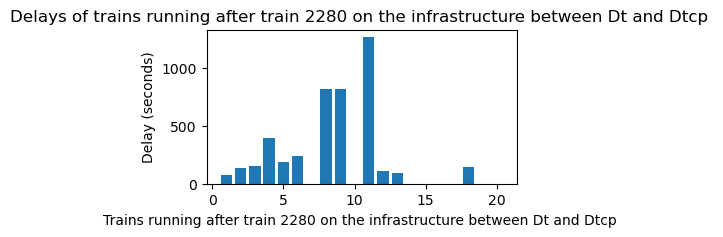

In [34]:
i = 0 # index in table small_delays FIND A NEW INDEX

plt.figure(figsize=(4, 2))
plt.bar(select_following_trains(i,20)['ORDER_ON_INFRA'], select_following_trains(i,20)['delay_seconds'])
plt.xlabel(f"Trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} " )
plt.ylabel('Delay (seconds)')
plt.title(f'Delays of trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} ')
plt.show()


Second example : 

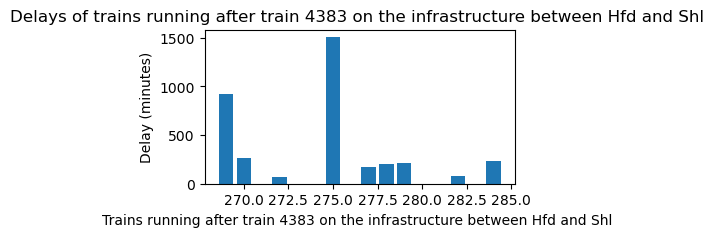

In [35]:
i = 160177 # index in table small_delays 

plt.figure(figsize=(4, 2))
plt.bar(select_following_trains(i,20)['ORDER_ON_INFRA'], select_following_trains(i,20)['delay_seconds'])
plt.xlabel(f"Trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} " )
plt.ylabel('Delay (minutes)')
plt.title(f'Delays of trains running after train {small_delays.loc[i, "BEWEGINGNUMMER"]} on the infrastructure between {small_delays.loc[i, "station1"]} and {small_delays.loc[i, "station2"]} ')
plt.show()

Now we represent the average delays (before, we would only focus on a specific train)

We create an attribute in small delays that recognize initial delays. 
Rules for being an initial delay : 
- The last 3 trains were delayed of 0 minutes
- The train is 3 times more delayed than any last 3 train

In [12]:
small_delays["initial_delay"]= False
for i, row in small_delays.iterrows() : 
    if row["delay_seconds"] >0 : 
        if row["ORDER_ON_INFRA"] >3 : 
            max_previous_delay  = max ([small_delays.loc[i-1, "delay_seconds"],
            small_delays.loc[i-2, "delay_seconds"],
            small_delays.loc[i-3, "delay_seconds"]])
            if max_previous_delay ==0 : small_delays.loc[i,"initial_delay"]= True
            if row["delay_seconds"] >= 3*max_previous_delay : small_delays.loc[i,"initial_delay"]= True
        if row["ORDER_ON_INFRA"] ==3 : 
            max_previous_delay  = max ([small_delays.loc[i-1, "delay_seconds"],
            small_delays.loc[i-2, "delay_seconds"]])
            if max_previous_delay ==0 : small_delays.loc[i,"initial_delay"]= True
        if row["ORDER_ON_INFRA"] ==2 : 
            if small_delays.loc[i-1, "delay_seconds"] ==0 :  row["initial_delay"]= True
        if row["ORDER_ON_INFRA"] ==1 :  small_delays.loc[i,"initial_delay"]= True
    


In [ ]:
def plot_propagation_of_delays(minute, small_delays):
    interval = [60 * minute - 30, 60 * minute + 30]

    # Select the trains in the interval
    base_trains = small_delays.loc[
        (small_delays["delay_seconds"] >= interval[0]) &
        (small_delays["delay_seconds"] < interval[1]) &
        (small_delays["initial_delay"] == True)
    ]

    merged = base_trains.merge(
        small_delays,
        on=["station1", "station2", "DAGNR"],
        suffixes=("_base", "_other")
    )

    merged["delta_order"] = (
        merged["ORDER_ON_INFRA_other"] - merged["ORDER_ON_INFRA_base"]
    )

    merged = merged[(merged["delta_order"] >= 0) & (merged["delta_order"] <= 20)& (merged["delay_seconds_other"] >0)]

    rows_to_delete = []

    for i, row in merged.iterrows():
        if (row["initial_delay_other"] == True)& (row["delta_order"]>0):
            to_delete = merged.loc[
                (merged["station1"] == row["station1"]) &
                (merged["station2"] == row["station2"]) &
                (merged["DAGNR"] == row["DAGNR"]) &
                (merged["delta_order"] >= row["delta_order"])
            ]
            rows_to_delete.extend(to_delete.index)  

    merged = merged.drop(index=rows_to_delete).reset_index(drop=True)

    
    merged["delta_order"] = (
        merged
        .sort_values(by=['DAGNR', 'station1', 'station2', 'UITVOERTIJD_VERTREK_dt_other'])
        .groupby(['index_base', 'DAGNR', 'station1', 'station2'])
        .cumcount() + 1     
        )
    
            
    # Compute both the mean delay and the count
    df_agg = (
        merged.groupby("delta_order")["delay_seconds_other"]
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={
            "delta_order": "ORDER_ON_INFRA_INDEX",
            "mean": "mean_delay_seconds",
            "count": "n_obs"
        })
    )

    # --- Plot ---
    fig, ax1 = plt.subplots(figsize=(5, 3.5))

    # Left y-axis: average delay
    bars1 = ax1.bar(
        df_agg["ORDER_ON_INFRA_INDEX"],
        df_agg["mean_delay_seconds"],
        color="steelblue",
        label="Mean delay (s)",
        width=0.6,
    )
    ax1.set_xlabel("Trains running on same infra after the 1st delayed train (ordered)")
    ax1.set_ylabel("Average delay (seconds)", color="steelblue")
    ax1.tick_params(axis='y', labelcolor="steelblue")

    # Right y-axis: number of data points
    ax2 = ax1.twinx()
    bars2 = ax2.bar(
        df_agg["ORDER_ON_INFRA_INDEX"],
        df_agg["n_obs"],
        color="orange",
        alpha=0.4,
        width=0.4,
        label="Number of trains",
    )
    ax2.set_ylabel("Number of trains (sample size)", color="orange")
    ax2.tick_params(axis='y', labelcolor="orange")

    # Title and layout
    plt.title(f"Propagation of delays for trains around {minute} min delay")
    fig.tight_layout()
    plt.show()


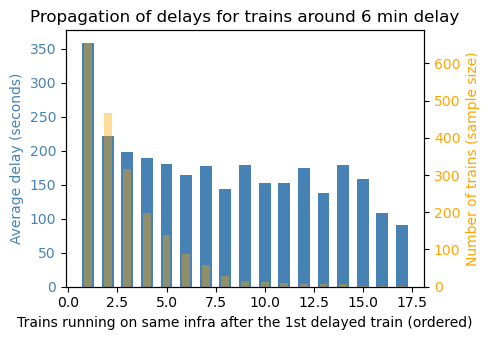

In [39]:
minute = 6
plot_propagation_of_delays(minute, small_delays)

The following graph synthetises the previous results for all small delays (from 3 to 10 minutes)

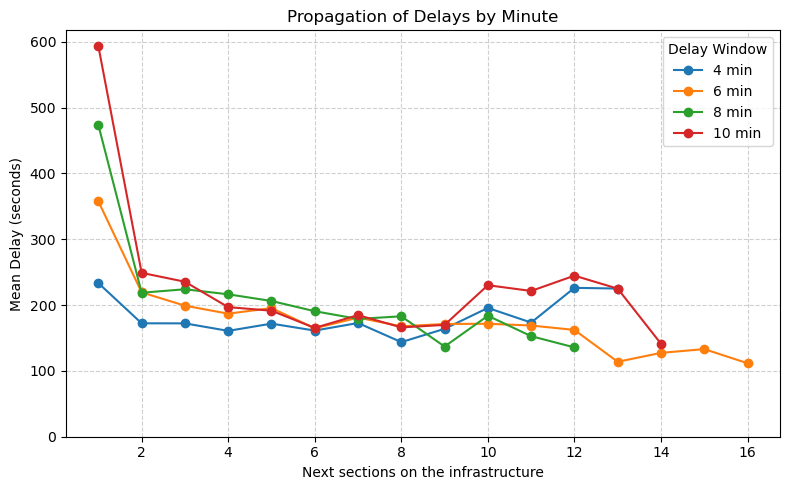

In [15]:
def agg_propagation_of_delays(minute, small_delays, limit=8):
    interval = [60 * minute - 60, 60 * minute + 60]

    # Select the trains in the interval
    base_trains = small_delays.loc[
        (small_delays["delay_seconds"] >= interval[0]) &
        (small_delays["delay_seconds"] < interval[1]) &
        (small_delays["initial_delay"] == True)
    ]

    merged = base_trains.merge(
        small_delays,
        on=["station1", "station2", "DAGNR"],
        suffixes=("_base", "_other")
    )

    merged["delta_order"] = (
        merged["ORDER_ON_INFRA_other"] - merged["ORDER_ON_INFRA_base"]
    )

    merged = merged[(merged["delta_order"] >= 0) & (merged["delta_order"] <= 20)& (merged["delay_seconds_other"] >0)]

    rows_to_delete = []

    for i, row in merged.iterrows():
        if (row["initial_delay_other"] == True)& (row["delta_order"]>0):
            to_delete = merged.loc[
                (merged["station1"] == row["station1"]) &
                (merged["station2"] == row["station2"]) &
                (merged["DAGNR"] == row["DAGNR"]) &
                (merged["delta_order"] >= row["delta_order"])
            ]
            rows_to_delete.extend(to_delete.index)  
    
    # Supprimer toutes les lignes à la fin
    merged = merged.drop(index=rows_to_delete).reset_index(drop=True)

    
    merged["delta_order"] = (
        merged
        .sort_values(by=['DAGNR', 'station1', 'station2', 'UITVOERTIJD_VERTREK_dt_other'])
        .groupby(['index_base', 'DAGNR', 'station1', 'station2'])
        .cumcount() + 1     
        )
    
            
    # Compute both the mean delay and the count
    df_agg = (
        merged.groupby("delta_order")["delay_seconds_other"]
        .agg(["mean", "count"])
        .reset_index()
        .rename(columns={
            "delta_order": "ORDER_ON_INFRA_INDEX",
            "mean": "mean_delay_seconds",
            "count": "n_obs"
        })
    )

    df_agg = df_agg.loc[df_agg["n_obs"] >limit]
    return df_agg

plt.figure(figsize=(8, 5))

for minute in [4,6,8,10]:
    df_agg = agg_propagation_of_delays(minute, small_delays, 8)
    plt.plot(
        df_agg['ORDER_ON_INFRA_INDEX'],
        df_agg["mean_delay_seconds"],
        label=f"{minute} min",      
        marker='o',             
        linestyle='-',             
        linewidth=1.5              
    )

plt.xlabel("Next sections on the infrastructure")
plt.ylabel("Mean Delay (seconds)")
plt.title("Propagation of Delays by Minute")
plt.legend(title="Delay Window")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.ylim(bottom=0)
plt.show()



## Crowding of trains after small delays

We want to know, when a train is delayed before it's terminus station, if it will be more crowded than forecasted on the rest of it's trip 

In [41]:
# Creation of a new attribute : IS_TERMINUS 

df_small_delays = df.copy()
df_small_delays['IS_TERMINUS'] = (
    df_small_delays.groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount(ascending=False) == 0
)
df_small_delays["delay"] = pd.to_datetime(df_small_delays["delay"], format="%H:%M:%S").dt.time
df_small_delays['delay_seconds'] = (df_small_delays['delay'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second))


In [42]:
# Select the trains that are delayed of a certain amount of time, but not at their terminus  
# stations (to observe the rest of their journey)

def make_list_index (minute) : 
    """
    It selects all the trains that are delayed BEFORE their terminus of a certain amount of minutes 
    (between minute-30 and minute+30)
    Args : 
        minute (int) : delay we want to consider
    Returns : 
        lst_index (list) : indexes of all the trains delayed before their terminus
    """
    interval = [60 * minute - 30, 60 * minute + 30]
    list_index = df_small_delays.loc[
        (df_small_delays["delay_seconds"] >= interval[0]) &
        (df_small_delays["delay_seconds"] < interval[1])&
        (df_small_delays["IS_TERMINUS"] == False) &
        (~ pd.isna(df_small_delays["delay_seconds"]))].index.tolist()
    return list_index
    

In [43]:
# Select the rest of their journeys after they encounter their first delay

minute =10

df_selected = df_small_delays.loc[make_list_index (minute)]
final_indices = set(make_list_index (minute)) 

for index in make_list_index (minute):
    row = df_small_delays.loc[index]
    mask = (
        (df_small_delays.index > index) &
        (df_small_delays['BEWEGINGNUMMER'] == row['BEWEGINGNUMMER']) &
        (df_small_delays['DAGNR'] == row['DAGNR'])
    )
    final_indices.update(df_small_delays.index[mask])

df_result = df_small_delays.loc[sorted(final_indices)]


In [44]:
# Order the rest of the services after the appartition of the delay

df_result['ORDER_ON_SERVICE'] = (
    df_result
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount() 
)

In [45]:
def plot_propagation_of_deviation(df_arg):
    """
    It plots, on one side, the deviation in prediction for the sections run by the same train after 
    the apparition of the delay
    Args : 
        df_arg (DataFrame) : df with all the sections run by a train after it is delayed 
    Returns : 
    """
    df_mean = (
                df_arg.groupby("ORDER_ON_SERVICE")["AFWIJKING"]
                .agg(mean_deviation=lambda x: x.abs().mean(), 
                     counted_data="count")
                .reset_index()
                .rename(columns={"ORDER_ON_SERVICE": "order_on_service"})
                )

    x = np.arange(len(df_mean)) # Positions of bars on X-axis
    width = 0.4
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Principal axis : mean_deviation
    bars1 = ax1.bar(x - width/2, df_mean["mean_deviation"], width, label="Mean deviation", color="purple")
    ax1.set_xlabel("Next sections after the apparition of the delay")
    ax1.set_ylabel("Mean deviation", color="purple")
    ax1.tick_params(axis="y", labelcolor="purple")
    ax1.set_ylim(0, df_mean["mean_deviation"].max() * 1.5)
    
    # Secondary axis : counted data
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + width/2, df_mean["counted_data"], width, label="Counted data", color="orange", alpha = 0.4)
    ax2.set_ylabel("Counted data", color="orange")
    ax2.tick_params(axis="y", labelcolor="orange")
    ax2.set_ylim(0, df_mean["counted_data"].max() * 1.5)
    
    # X-Axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(df_mean["order_on_service"])
    
    plt.title(f"Propagation of deviation for trains delayed of {minute} minutes before their terminus")
    fig.tight_layout()
    bars = [bars1, bars2]
    labels = [b.get_label() for b in bars]
    ax1.legend(bars, labels, loc="upper left")   
    plt.show()


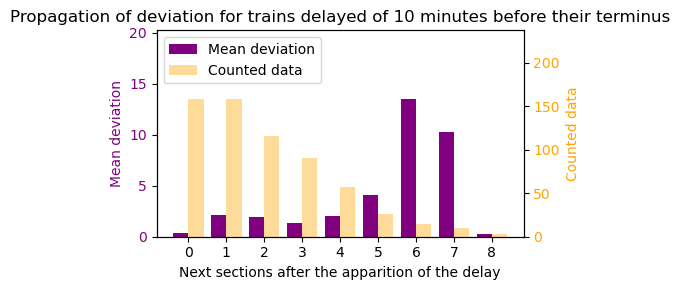

In [46]:
plot_propagation_of_deviation(df_result)

And here is the comparison to the evolution of deviation of all the trains, without considering their delays

In [47]:
df_small_delays['ORDER_ON_SERVICE'] = (
    df_small_delays
    .groupby(['DAGNR', 'BEWEGINGNUMMER'])
    .cumcount()  
)

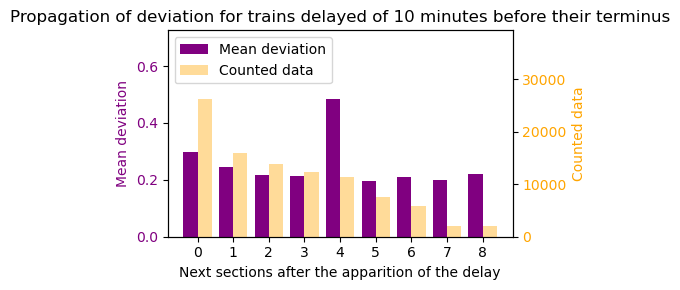

In [48]:
plot_propagation_of_deviation(df_small_delays.loc[(~ pd.isna(df_small_delays["delay_seconds"]))])

### Separate on the infrastructures

Only on the slow line between Rotterdam Central and Shiphol

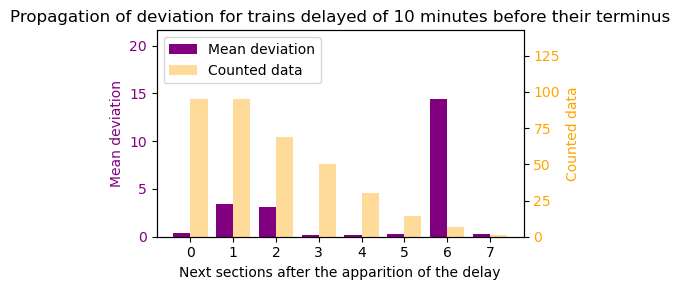

In [50]:
plot_propagation_of_deviation(df_result.loc[df_result["global_infra_name"].isin(['Slow_Rtd_Shl','Slow_Rtd_Gvc','Slow_Gvc_Shl'])] )

Only on the slow lines between Schiphol and Rotterdam Central

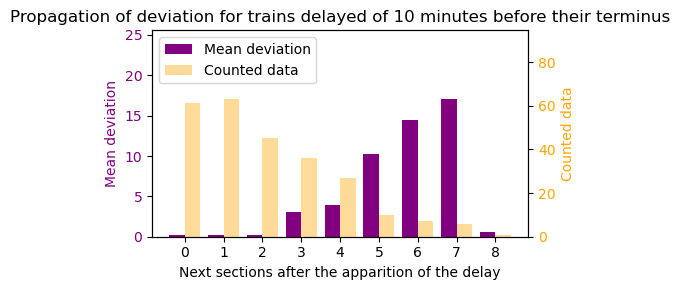

In [51]:
plot_propagation_of_deviation(df_result.loc[df_result["global_infra_name"].isin(['Slow_Shl_Rtd','Slow_Gvc_Rtd','Slow_Shl_Gvc'])] )


## People changing their journey themselves

We want to check if, for trains with small delays, people board on other trains departing from the same station, instead of waiting for their train to arrive

In [52]:
minute = 10
final_indices_replacement =set() 

for idx in make_list_index (minute) :
    row = df_small_delays.loc[idx]
    mask = (
        (df_small_delays['UITVOERTIJD_VERTREK'] > row['PLANTIJD_VERTREK']) &
        (df_small_delays['UITVOERTIJD_VERTREK'] < row['PLANTIJD_VERTREK']+pd.to_timedelta(f"{minute} minutes")) &
        (df_small_delays['DAGNR'] == row['DAGNR'])& 
        (df_small_delays['station1'] == row['station2'])&
        (~ pd.isna(df_small_delays["delay_seconds"]))
    )
    final_indices_replacement.update(df_small_delays.index[mask])

df_replacement_final = df_small_delays.loc[sorted(final_indices_replacement)]

In [53]:
mean_deviation_with_delay = df_replacement_final["AFWIJKING"].mean()
mean_deviation_with_delay

np.float64(-0.005602280462291664)

In [54]:
mean_deviation = df_small_delays.loc[(~ pd.isna(df_small_delays["delay_seconds"])),"AFWIJKING"].mean()
mean_deviation

np.float64(0.09498207829783699)

We see that people don't change train in a significative way instead of waiting for their late train to arriveWe see that people don't change train in a significative way instead of waiting for their late train to arrive. Or maybe they do, but we can't evaluate it with the attribute AFWIJKING.

# Influence of weather conditions

In [75]:
df_meteo = df_meteo.rename(columns={
    '    R': 'R', 
    '    O': 'O',
    '   FH': 'FH',
    '   RH': 'RH'  
})

df_merge_meteo = df.copy() 
df_merge_meteo['PLANTIJD_VERTREK_hour']=df_merge_meteo['PLANTIJD_VERTREK'].dt.components.hours
df_merge_meteo= pd.merge(df_merge_meteo, 
                         df_meteo[['# STN', 'Day', 'HH', 'FH', 'RH', 'R', 'O']], 
                         left_on = ['DAGNR', 'PLANTIJD_VERTREK_hour'], 
                         right_on = ['Day', 'HH'])




Mean deviation based on different factors

In [76]:
# Presence of rain
mask = df_merge_meteo.loc[(df_merge_meteo['R']==1)&(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation with some rain (heavy or not) : {round(mask['AFWIJKING'].abs().mean(),3)*100}%")

#Presence of thunder 
mask = df_merge_meteo.loc[(df_merge_meteo['O']==1)&(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation with some thunder : {round(mask['AFWIJKING'].abs().mean(),3)*100}%")

# Without rain or thunder 
mask = df_merge_meteo.loc[(df_merge_meteo['O']==0) & (df_merge_meteo['R']==0) &(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation without rain or thunder : {round(mask['AFWIJKING'].abs().mean(),3)*100}%")

# Total 
print (f"Average deviation in general : {round(df_merge_meteo[(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]['AFWIJKING'].abs().mean(),3)*100}%")

# With heady wind : 
mask = df_merge_meteo.loc[(df_merge_meteo['Gusts']=='Heavy Wind')  &(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation with heavy wind : {round(mask['AFWIJKING'].abs().mean(),3)*100}%")

# With heavy rain
mask = df_merge_meteo.loc[(df_merge_meteo['Rain']=='Heavy Rain')  &(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation with heavy rain : {round(mask['AFWIJKING'].abs().mean(),3)*100}%")

# With basic rain
mask = df_merge_meteo.loc[(df_merge_meteo['Rain']=='Rain')  &(df_merge_meteo['Cancelled']==False) &(df_merge_meteo['ExtraTrain']==False)]
print (f"Average deviation with basic rain : {round(mask['AFWIJKING'].abs().mean(),2)*100}%")



Average deviation with some rain (heavy or not) : 39.4%
Average deviation with some thunder : 21.2%
Average deviation without rain or thunder : 23.7%
Average deviation in general : 26.6%
Average deviation with heavy wind : 20.5%
Average deviation with heavy rain : 20.4%
Average deviation with basic rain : 41.0%


Graph with the amount of rain, the average delay, the average deviation

In [77]:
df_merge_meteo['delay'] = pd.to_datetime(df_merge_meteo["delay"], format="%H:%M:%S").dt.time
df_merge_meteo['delay_seconds'] = (df_merge_meteo['delay'].apply(lambda t: t.hour * 3600 + t.minute * 60 + t.second))

df_merge_meteo = df_merge_meteo.loc[(df_merge_meteo["Cancelled"]==False) & 
                                    (df_merge_meteo["ExtraTrain"]==False)]
df_meteo_graph = df_merge_meteo.groupby("DAGNR").agg({
    "AFWIJKING": lambda x: x.abs().mean(),
    "REALISATIE" : "sum", 
    "delay_seconds": "mean"
})
df_meteo_bis = df_meteo.groupby("Day").agg({"RH" : 'sum',
                                           "FH": 'mean'})
df_meteo_bis.loc[df_meteo_bis["RH"]<0,"RH"]= 0

df_meteo_graph = pd.merge(df_meteo_graph, 
                          df_meteo_bis, 
                          left_index=True, 
                          right_on= "Day")

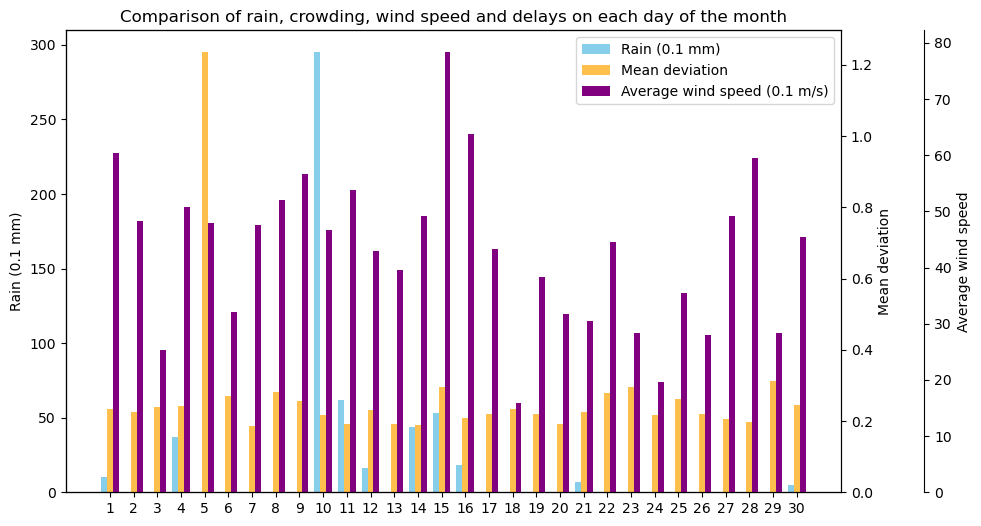

In [78]:
x = np.arange(len(df_meteo_graph.index))         
width = 0.25
fig, ax1 = plt.subplots(figsize=(10,6))


bars1 = ax1.bar(x - width, df_meteo_graph["RH"], width, color='skyblue', label="Rain (0.1 mm)")
ax1.set_ylabel("Rain (0.1 mm)")
ax1.set_xticks(x)
ax1.set_xticklabels(df_meteo_graph.index)

ax2 = ax1.twinx()  
bars2 = ax2.bar(x, df_meteo_graph["AFWIJKING"], width, color='orange', label="Mean deviation", alpha=0.7)
ax2.set_ylabel("Mean deviation")

ax3 = ax1.twinx()  
ax3.spines["right"].set_position(("outward", 60))
bars3 = ax3.bar(x + width , df_meteo_graph["FH"], width, color='purple', label="Average wind speed")
ax3.set_ylabel("Average wind speed")

bars = bars1 + bars2 + bars3 
labels = [b.get_label() for b in bars]
ax1.legend([bars1, bars2, bars3], ["Rain (0.1 mm)", "Mean deviation","Average wind speed (0.1 m/s)"], loc='upper right')

plt.title("Comparison of rain, crowding, wind speed and delays on each day of the month")
plt.show()


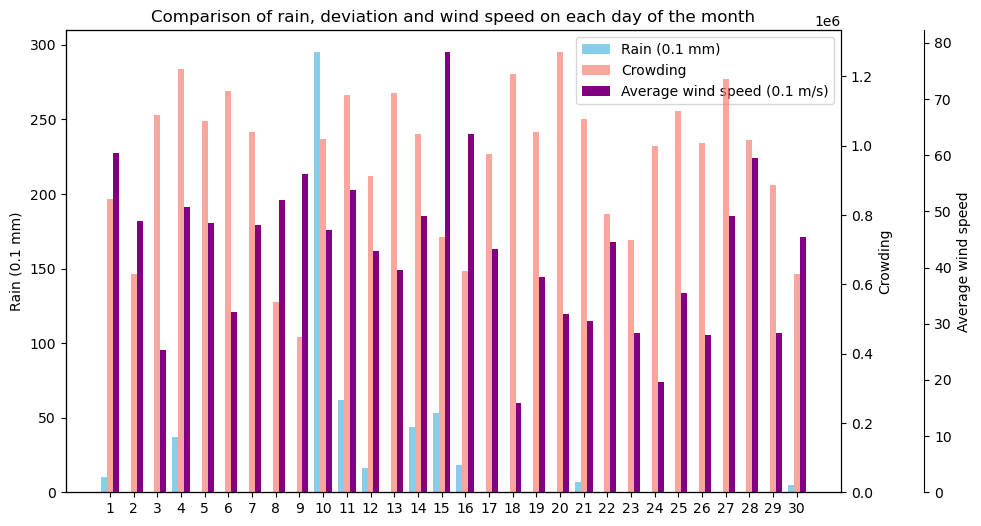

In [79]:
x = np.arange(len(df_meteo_graph.index))         
width = 0.25
fig, ax1 = plt.subplots(figsize=(10,6))


bars1 = ax1.bar(x - width, df_meteo_graph["RH"], width, color='skyblue', label="Rain (0.1 mm)")
ax1.set_ylabel("Rain (0.1 mm)")
ax1.set_xticks(x)
ax1.set_xticklabels(df_meteo_graph.index)

ax2 = ax1.twinx()  
bars2 = ax2.bar(x, df_meteo_graph["REALISATIE"], width, color='salmon', label="Crowding", alpha=0.7)
ax2.set_ylabel("Crowding")

ax3 = ax1.twinx()  
ax3.spines["right"].set_position(("outward", 60))
bars3 = ax3.bar(x + width , df_meteo_graph["FH"], width, color='purple', label="Average wind speed")
ax3.set_ylabel("Average wind speed")

bars = bars1 + bars2 + bars3 
labels = [b.get_label() for b in bars]
ax1.legend([bars1, bars2, bars3], ["Rain (0.1 mm)", "Crowding", "Average wind speed (0.1 m/s)"], loc='upper right')

plt.title("Comparison of rain, deviation and wind speed on each day of the month")
plt.show()

In [82]:
day=10
df_june_10 = df_merge_meteo.loc[df_merge_meteo["DAGNR"]==day].groupby("HH").agg({
    "RH" : "first",
    "FH" : "first", 
    "AFWIJKING": lambda x: x.abs().mean(), 
    "REALISATIE" : "sum"})

df_june_10["RH"] = df_june_10["RH"].astype(float)
df_june_10.loc[df_june_10["RH"] < 0, "RH"] *= -0.5

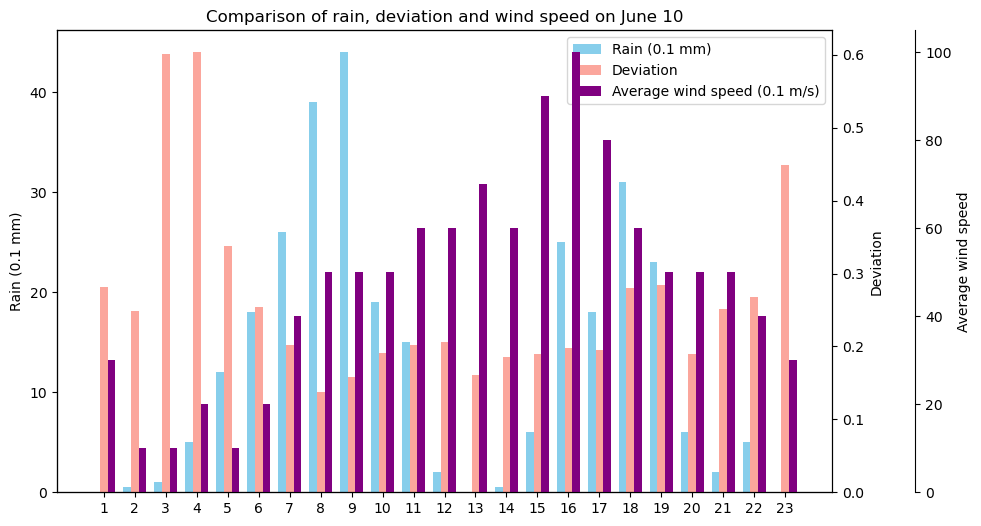

In [83]:
x = np.arange(len(df_june_10.index))         
width = 0.25
fig, ax1 = plt.subplots(figsize=(10,6))


bars1 = ax1.bar(x - width, df_june_10["RH"], width, color='skyblue', label="Rain (0.1 mm)")
ax1.set_ylabel("Rain (0.1 mm)")
ax1.set_xticks(x)
ax1.set_xticklabels(df_june_10.index)

ax2 = ax1.twinx()  
bars2 = ax2.bar(x, df_june_10["AFWIJKING"], width, color='salmon', label="Mean deviation", alpha=0.7)
ax2.set_ylabel("Deviation")

ax3 = ax1.twinx()  
ax3.spines["right"].set_position(("outward", 60))
bars3 = ax3.bar(x + width , df_june_10["FH"], width, color='purple', label="Average wind speed")
ax3.set_ylabel("Average wind speed")

bars = bars1 + bars2 + bars3 
labels = [b.get_label() for b in bars]
ax1.legend([bars1, bars2, bars3], ["Rain (0.1 mm)", "Deviation", "Average wind speed (0.1 m/s)"], loc='upper right')

plt.title(f"Comparison of rain, deviation and wind speed on June {day}")
plt.show()